### Alvaro Plata (201820098), Brenda Barahona (201812721) , Sofía Álvarez (201729031)

<h1 align='center'>Laboratorio 2: Inteligencia de Negocios</h1>

BancAlpes es una entidad bancaria que está realizando una campaña de fidelización para aumentar la retención de clientes. En concreto, con su estrategía busca fidelizar especialmente a las personas que poseen tarjetas de crédito.
Esta campaña busca ofrecer los mejores productos, servicios y recomendaciones a sus clientes de acuerdo con sus características.
Por esta razón, ha recurrido a ustedes como consultores para que le entreguen al equipo de marketing información que pueda ayudarlos a orientar mejor sus campañas.
En particular, el equipo de marketing espera que le provean grupos a los cuales pueden dirigir sus campañas y las caracteristicas de los clientes en dichos grupos.
BancAlpes considera que esta nueva estrategia de marketing le permitirá aumentar el consumo de productos y servicios y por supuesto, aumentar la retención de clientes.

## 0. Librerias.

In [1]:
# ESAI
# Importamos todas las librerias necesarias para el laboratorio.
import re
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
from matplotlib import cm
from joblib import dump, load
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.impute import SimpleImputer
from pandas_profiling import ProfileReport
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cluster import AgglomerativeClustering
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.metrics import recall_score, make_scorer
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

## 1. Análisis exploratorio y perfilamiento de los datos.

En esta etapa sabremos cuántos datos tenemos (filas y columnas), el tipo de datos de las columnas, cual es la integridad de los datos, cuál es su distribución (discreta o continua). Ademas, para el caso de las columnas numéricas, usaremos estadística descriptiva sobre los datos, y señalaremos sus principales estadísticos: media, varianza, desviación estándar, etc.  En caso de datos categóricos conoceremos las categorías, los números de registro por categoría, en especial para las categorías con mayor representación en los datos.

Primero leemos los datos y sacamos una muestra, como se ve a continuación:

In [2]:
datos = pd.read_csv('202210_Laboratorio2_data_202210_Lab2_BancAlpes_CC_data.csv', delimiter=',')
datos.sample(5)

CUST_ID GENDER      BALANCE  PURCHASES  BALANCE_FREQUENCY CASH_ADVANCE  \
3469  C10886    NaN  2173.621597     200.00           1.000000   201.404735   
4810  C10141      M  1562.633343    1330.62           1.000000          0.0   
2566  C18506    NaN   279.811953     399.90           1.000000          0.0   
2114  C12918      F   302.091029       0.00           0.818182  3688.086261   
1050  C13359      M  6209.488896       0.00           1.000000  3674.314806   

      CASH_ADVANCE_TRX  PURCHASES_FREQUENCY PURCHASES_TRX  \
3469               4.0             0.083333             1   
4810               NaN             0.500000             8   
2566               0.0             1.000000            14   
2114               8.0             0.000000             0   
1050               3.0             0.000000             0   

      ONEOFF_PURCHASES_FREQUENCY  CASH_ADVANCE_FREQUENCY  CREDIT_LIMIT  \
3469                    0.083333                0.250000        8000.0   
4810                    0.166667                0.000000        2000.0   
2566                         NaN                0.000000        1000.0   
2114                    0.000000                0.166667        2000.0   
1050                         NaN                0.166667        8500.0   

         PAYMENTS MINIMUM_PAYMENTS TENURE  
3469   495.968187       502.765453     12  
4810  1020.783647       709.610053     12  
2566   538.655831       195.433258     12  
2114  4032.526313      87.872257?ñ     12  
1050  1417.169060      1425.192934     12

Veamos, ahora, el número de filas y columnas que tenemos en nuestro conjunto de datos:

In [3]:
print("Número de filas o datos: {}".format(len(datos)))
print("Número de columnas o variables: {}".format(len(datos.columns)))

Número de filas o datos: 5530
Número de columnas o variables: 15


Vemos que tenemos 5530 datos (filas) y 15 columnas (variables). Comparando con el diccionario de datos, vemos que el negocio nos entregó 15 columnas también.

Para ver una exploración más exhaustiva, hicimos un <code>pandas profiling</code> de los datos que nos fueron entregados: 

In [4]:
profiling = ProfileReport(datos)
profiling.to_file(output_file="pandas_profiling.html")
profiling

Summarize dataset:   0%|          | 0/28 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Haciendo un perfilamiento y análisis exploratorio sobre los datos, encontramos lo siguiente:

<b>Estadísticas generales</b>: Primero, tenemos 5933 celdas con ausencias, lo que corresponde al 7.2% del total del dataset. Para ellas, más adelante, debe implementarse una estrategia de imputación o eliminación, según sea el caso, como se verá más adelante. Asimismo, vemos que no tenemos filas duplicadas.

Las variables que tienen valores vacios son: 
* **OneOffPurchases_frequency** con 2740 celdas vacías (i.e. 49.5%).
* **Gender** con 2714 celdas vacías (i.e. 49.1%).
* **Cash_advance_frequency** con 166 celdas vacías (i.e. 3%).
* **Tenure** con 163 celdas vacías (i.e. 2.9%).
* **Cash_Advance_Trx** con 150 celdas vacías (i.e. 2.7%).

Preliminarmente, podemos ver que las dos primeras variables descritas tienen casi la mitad de ausencias y, posiblemente, deban ser eliminadas del análisis. 

Asimismo, se tienen 9 variables numéricas y 6 categóricas. Esto NO concuerda con el diccionario dado por BancAlpes. Encontramos que el tipo de dato identificado por pandas profiling es incorrecto para las siguientes variables, según lo indicado por el documento del diccionario, pues estas variable deben ser numéricas y fueron clasificadas como categóricas: 
* **CashAdvance:** De acuerdo con el diccionario de datos, es numérica. No obstante, pandas profiling la determina como categórica por la presencia de valores como ?? u otros, en teoría numéricos, que finalizan con ?ñ, como 00.?ñ. Esto debe tratarse en la limpieza de datos, seguramente asumiéndolos como errores de tipeo. 
* **PurchasesTrx:** En este caso, la variable debe ser numérica también. Por tener caracteres con ?, pandas profiling la etiqueta como categórica. Esto debe tratarse en la limpieza de datos, seguramente asumiéndolos como errores de tipeo.
* **Minimum_payments:** Debe ser numérica y es catalogada como categórica por la presencia de caracteres como ??, ñ?, ?. De nuevo, esto será tratado más adelante.
* **Tenure:** Debe ser numérica y, por caracteres extraños como ?, ñ en algunas celdas (o acompañando a ciertos valores numéricos), es definida como categórica.

Para todas estas variables, hay algunos datos con inconsistencias o datos atípicos y, por tanto, deben ser procesados más adelante. 

Ahora, de las variables catalogadas como numéricas, tenemos que las que tienen una distribución continua son:
* **Balance:** Es una variable real distribuida en el rango [-4587.892398, 7390.19856]. De acuerdo con el diccionario y los expertos, esta debe ser siempre positiva y estar en el rango [0, 5000].
* **Balance_frequency:** De acuerdo con el negocio, debe estar distribuida entre 0 y 1. Vemos algunos outliers en 1000.
* **Purchases:** Es una variable real distribuida en el rango [0, 9661.37]. De acuerdo con el negocio, debe estar distribuida entre [0, 15000], por lo que concluimos que los valores se encuentran en el rango definido. Nos parece curioso que haya valores decimales, pues según Bancalpes, esta variable representa la cantidad de compras realizadas por los clientes, y estas deberían ser números enteros. Suponemos, entonces, que se refiere al número promedio de compras realizadas por una cuenta en un intervalo de tiempo determinado.
* **OneOffPurchasesFrequency:** Tiene una distribución continua entre 0 y 1, como es de esperarse de acuerdo con los expertos.
* **Purchases_frequency:** De acuerdo con el negocio, debe estar distribuida entre 0 y 1. Vemos algunos outliers en 1000.

* **Cash_advance_frequency:** Tiene una distribución continua entre 0 y 1.5, cuando su valor máximo debería ser 1. Vemos entonces que hay datos fuera de rango.
* **Credit_limit:** Es una variable con distribución continua en el rango [50, 12500]. De acuerdo con el negocio, esta variable, que representa límite de crédito por usuario, debe estar distribuida entre [0, 10000]. Vemos que hay algunos pocos valores que se salen del límite superior. No obstante, puede tener sentido que algunos usuarios tengan un límite crediticio entre [10000, 12500]. Este tipo de decisiones las trataremos más adelante.  
* **Payments:** Cantidad pagada por el usuario, debe estar distribuida entre [0, 10000] y se encuentra en el rango [0.056466, 9933.62261]. Está adecuadamente distribuida según el negocio.

Además de las variables antes mencionadas, encontramos que hay otras que tambien siguen una distribución continua y que, debido a los outliers y los valores corruptos (i.e. con ñ), no se evidenciaba una clara distribucion de los datos, ya que los rangos con los que pandas contruyó el histograma eran muy grandes.

Por otro lado, vemos que las variables numéricas con distribución discreta son:
* **CashAdvanceTrx:** Parece ser que tiene una distribución discreta, lo cual concuerda con la descripción dada en el diccionario. No obstante, tiene muchos outliers y es difícil saberlo.
* **PurchasesTrx:** Sucede algo similar que con CashAdvanceTrx. 

Un análisis más detallado de las variables numéricas se hará más adelante.

Asimismo, las variables (realmente) categóricas son:
* **CustID:** La identificación del cliente, en que todos los valores son únicos. No da información relevante para el modelo de agrupación.
* **Gender:** Representa el género de la persona. Tiene muchas ausencias, como se mencionó previamente. Una distribución de esta variable la veremos más adelante.

Vemos entonces que la calidad de los datos, en general, no es muy buena. No sólo hay variables con datos fuera de rango según lo definido por el negocio; sino que, además, hay algunos datos inconsistentes (con ?, ñ?, ??, por ejemplo) o nulos (vacíos). Para poder implementar los modelos, es necesario corregir estas inconsistencias en los datos. 

##### Variables numéricas:
Veamos estadísticas descriptivas sobre los datos numéricos:

In [5]:
datos.describe()

BALANCE    PURCHASES  BALANCE_FREQUENCY  CASH_ADVANCE_TRX  \
count  5530.000000  5530.000000        5530.000000       5380.000000   
mean   1041.700463   534.577103          26.482552         49.115428   
std    1353.093044   773.488745         152.899316        573.817771   
min   -4587.892398     0.000000           0.000000          0.000000   
25%      74.060304     0.000000           0.833333          0.000000   
50%     632.743635   269.130000           1.000000          0.000000   
75%    1545.808455   723.700000           1.000000          3.000000   
max    7390.198560  9661.370000        1000.000000      18000.000000   

       PURCHASES_FREQUENCY  ONEOFF_PURCHASES_FREQUENCY  \
count          5530.000000                 2790.000000   
mean             12.206006                    0.148298   
std              93.757671                    0.241687   
min               0.000000                    0.000000   
25%               0.000000                    0.000000   
50%               0.363636                    0.000000   
75%               0.833333                    0.166667   
max            1000.000000                    1.000000   

       CASH_ADVANCE_FREQUENCY  CREDIT_LIMIT     PAYMENTS  
count             5364.000000   5530.000000  5530.000000  
mean                 0.119005   3588.095256  1107.989817  
std                  0.173206   2640.396238  1270.892564  
min                  0.000000     50.000000     0.056466  
25%                  0.000000   1500.000000   345.431102  
50%                  0.000000   2900.000000   671.001699  
75%                  0.166667   5000.000000  1354.931507  
max                  1.500000  12500.000000  9933.622610

En este punto, podemos obtener información más detallada sobre las variables numéricas. Veamos:
* **BALANCE:** Como se dijo previamente, los valores de esta variable están fuera del rango, tanto inferior (0) como superior (5000), definido por el negocio. Vemos que el valor mínimo es -4587; no obstante, son poquitos los datos negativos porque, por lo menos, el percentil 25 está en 74.06. Ahora, el máximo es 7390; pero, de igual forma, el percentil 75 está en 1545, tal que no hay muchos datos que superen el límite superior. Esto se verá con más detalle en el preprocesamiento de los datos.
* **PURCHASES:** Es una variable real distribuida en el rango [0, 9661.37]. De acuerdo con el negocio, debe estar distribuida entre [0, 15000], por lo que concluimos que los valores se encuentran en el rango definido. Nos parece curioso que haya valores decimales, pues según Bancalpes, esta variable representa la cantidad de compras realizadas por los clientes, y estas deberían ser números enteros. Suponemos, entonces, que se refiere al número promedio de compras realizadas por una cuenta en un intervalo de tiempo determinado.
* **BALANCE_FREQUENCY:** De acuerdo con el negocio, debe estar distribuida entre 0 y 1. Vemos algunos outliers en 1000 (el valor máximo), que pueden ser producto de errores de tipeo (1000 en lugar de 1). Son pocos, pues por lo menos el 75% de los datos es menor o igual a 1 y mayor o igual a 0. Más adelante, trataremos esto. 
* **CASH_ADVANCE_TRX:** Parece ser que tiene una distribución discreta, lo cual concuerda con la descripción dada en el diccionario. No obstante, tiene muchos outliers y es difícil saberlo. Confimamos que el valor máximo es 18000, bastante alejado del valor máximo que, en este caso, es 15. Por estos outliers, la media está muy desplazada. En este caso, se encuentra en 49.1 (pues la media es un estadístico sensible a valores extremos). A diferencia de las anteriores, tiene 150 valores nulos.
* **PURCHASES_FREQUENCY:** Similar A BALANCE_FREQUENCY, debería estar distribuida entre 0 y 1 pero tiene outliers en 1000 (el valor máximo), que pueden ser producto de errores de tipeo (1000 en lugar de 1). Son pocos, pues por lo menos el 75% de los datos es menor o igual a 1 y mayor o igual a 0. Más adelante, trataremos esto.
* **ONEOFF_PURCHASES_FREQUENCY:** Esta variable tiene casi la mitad de valores nulos; por lo tanto, es difícil dar información sobre ella. Vemos que los valores están en el rango [0,1] definido por el negocio. Consideramos que no es tan relevante para el negocio dada la cantidad de valores nulos.
* **CASH_ADVANCE_FREQUENCY:** Tiene una distribución continua entre 0 y 1.5, cuando su valor máximo debería ser 1. Vemos entonces que hay datos fuera de rango. No obstante, deben ser pocos; pues el percentil 75 se encuentra en 0.166. Tiene ciertos valores nulos, que deberán tratarse más adelante.
* **CREDIT_LIMIT:** Es una variable con distribución continua en el rango [50, 12500]. De acuerdo con el negocio, esta variable, que representa límite de crédito por usuario, debe estar distribuida entre [0, 10000]. Vemos que hay algunos pocos valores que se salen del límite superior. No obstante, puede tener sentido que algunos usuarios tengan un límite crediticio entre [10000, 12500]; además de que, como vemos, el percentil 75 está en 5000 (no deben ser muchos los datos por encima del rango). De acuerdo con su media (3588) y desviación estándar (2640), vemos que los datos están dispersos.
* **PAYMENTS:** Cantidad pagada por el usuario, debe estar distribuida entre [0, 10000] y se encuentra en el rango [0.056466, 9933.62261]. Está adecuadamente distribuida según el negocio. Todos los datos están completos, su media está en 1107 y su desviación estándar en 1270. Los datos son, entonces, bastante dispersos.

Note que en este análisis no es posible hablar de las variables numéricas con datos atípicos o inconsistencias (?, ñ?, por ejemplo), porque no se detectan como valores numéricos por python. 

Finalmente, dependiendo del algoritmo a utilizar, se hace a veces necesario entender la correlación entre las distintas variables. Veamos un mapa de correlación entre las variables numéricas:

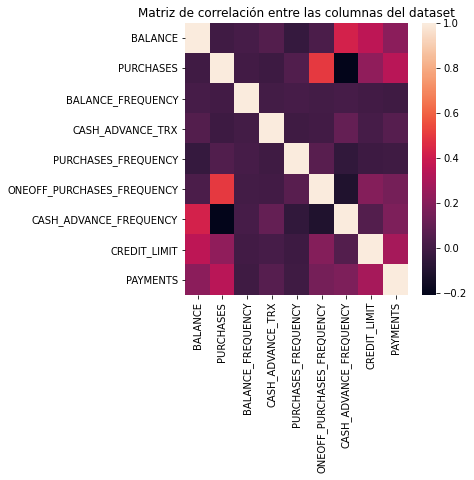

In [6]:
corr = datos.corr()

plt.figure(figsize=(5,5))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
plt.title('Matriz de correlación entre las columnas del dataset')
plt.show()

Podemos ver que no hay correlaciones ni positivas ni negativas muy fuertes entre los datos. La correlación positiva más alta, de alrededor de 0.6, es entre PURCHASES_FREQUENCY y ONEOFF_PURCHASES_FREQUENCY. Quizá podría pensarse en eliminarse alguna de estas columnas, pero estas son decisiones que deben tomarse más adelante.

##### Variables categóricas:
En caso de datos categóricos según el diccionario conoceremos las categorías, los números de registro por categoría, en especial para las categorías con mayor representación en los datos. En este caso, veremos sólo la distribución de género; pues de acuerdo con el pandas profiling, los datos de los IDs de los consumidores son únicos.

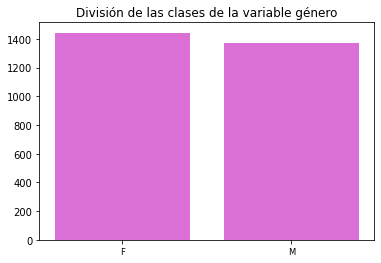

Veamos la cantidad de datos en cada clase: 


GENDER
F    1443
M    1373

In [7]:
val_counts_gender = datos['GENDER'].value_counts()
plt.bar(range(len(val_counts_gender)), val_counts_gender.values, align='center',color='orchid')
plt.xticks(range(len(val_counts_gender)), val_counts_gender.index.values, size='small')
plt.title('División de las clases de la variable género')
plt.show()
print('Veamos la cantidad de datos en cada clase: ')
datos['GENDER'].value_counts().to_frame()

Podemos ver que hay una cantidad de datos de cada categoría muy parecida; no obstante, teniendo en cuenta la cantidad total de datos del dataset, podemos ver que hay ciertos valores nulos (la totalidad de ambas categorías no suma el total de datos).

**NOTA:** Es importante mencionar que, en el contexto de las tareas por agrupación y dado el enunciado, no es necesario hacer una partición train-test de los datos. 

## 2. Preparación de datos.

Realizaremos el proceso para garantizar la calidad de los datos antes de correr los algoritmos.

### Eliminación de columnas 

La columna CUSTID es la identificacion de la tarjeta de crédito. Como esta columna no representa ningún dato significativo para el proceso de la creación del modelo, procedemos a eliminarla. Esto se debe a que los IDs no son relevantes en la mayoría de trabajos de aprendizaje automático. 

Como se indicó en el perfilamiento de los datos, las columnas OneOffPurchases_frecuency y Gender cuentan con un porcentaje de celdas faltantes significativo: 49.5% y 49.1%, respectivamente. Por esta razón si realizamos imputación de datos para estas columnas, estaríamos sesgando los datos, por lo que también serán eliminadas.

In [8]:
datos.drop(["GENDER", "CUST_ID", "ONEOFF_PURCHASES_FREQUENCY"], axis=1, inplace=True)
print("Número de filas o datos: {}".format(len(datos)))
print("Número de columnas o variables: {}".format(len(datos.columns)))

Número de filas o datos: 5530
Número de columnas o variables: 12


### Manejo de valores atipicos / no válidos
Primero, revisaremos cuales son los datos no válidos que tenemos en los datos, como los que identificamos con ??, ñ? en el perfilamiento.

In [9]:
def get_not_numeric_values(datos):
    # Vemos todos los valores distintos (únicos) que tiene el dataframe.
    valores_distintos = list(datos.apply(pd.value_counts).index)
    valores_no_numericos = []
    # Interamos sobre los valores distintos
    for val in valores_distintos:
        try:
            # Intentamos hacer el cast a float
            numero = float(val)
        except:
            # Si hay datos no numericos, los agregamos a la lista
            valores_no_numericos.append(val)
    return valores_no_numericos

In [10]:
valores_no_numericos=get_not_numeric_values(datos)
print('Los valores no numéricos son:\n {}'.format(', '.join(map(str,valores_no_numericos))))

Los valores no numéricos son:
 0.0?ñ, 0?ñ, 1.721007?ñ, 1090.811625?ñ, 10?ñ, 1117.265123?ñ, 117.258435?ñ, 11?ñ, 120.178123?ñ, 1210.778254?ñ, 1222.355238?ñ, 1227.092304?ñ, 1232.547913?ñ, 1253.401339?ñ, 1254.849545?ñ, 1265.552953?ñ, 127.542299?ñ, 1297.077512?ñ, 1299.253842?ñ, 12?ñ, 130.626533?ñ, 1344.577203?ñ, 135.26688?ñ, 139.382867?ñ, 1414.866215?ñ, 1452.265916?ñ, 1454.215974?ñ, 1460.777849?ñ, 147.347019?ñ, 1480.171443?ñ, 149.110815?ñ, 14?ñ, 1516.892745?ñ, 158.851964?ñ, 15?ñ, 162.269258?ñ, 162.941232?ñ, 163.353616?ñ, 167.584529?ñ, 168.805075?ñ, 1708.514116?ñ, 172.574308?ñ, 175.755159?ñ, 178.143055?ñ, 178.313275?ñ, 17?ñ, 18.904244?ñ, 183.230915?ñ, 184.288462?ñ, 185.805592?ñ, 1863.759832?ñ, 188.591146?ñ, 1983.897997?ñ, 19?ñ, 1?ñ, 200.254118?ñ, 202.991548?ñ, 216.195821?ñ, 21?ñ, 229.289946?ñ, 229.94082?ñ, 22?ñ, 233.788637?ñ, 234.095576?ñ, 237.378894?ñ, 239.606651?ñ, 23?ñ, 247.32444?ñ, 254.022569?ñ, 2555.103715?ñ, 25?ñ, 2625.644609?ñ, 269.655125?ñ, 26?ñ, 2705.839993?ñ, 271.370767?ñ, 273.5254

Podemos ver que la mayoria de estos datos no válidos tienen un número y al final un "?ñ". Asumiremos que esto fue un error de tipeo al momento de ingresar los datos, por lo que eliminaremos el "?ñ" y dejaremos el número. Mas adelante revisaremos si los datos cumplen con los rangos establecidos.
La siguiente funcion nos ayudará a limpiar estos datos:

In [11]:
# Function to clean the names-https://www.geeksforgeeks.org/replace-values-in-pandas-dataframe-using-regex/
def clean_numbers(Column_name):

    if re.search('\?ñ', Column_name): 
        # Extract the position of beginning of pattern
        pos = re.search('\?ñ', Column_name).start()
        # return the cleaned name
        return Column_name[:pos]
  
    else:
        # if clean up needed return the same name
        return Column_name

Aplicamos la funcion anterior en todas las columnas. Como estamos trabajando con expresiones regulares, evitaremos errores, se convierten todos valores a <code>str</code>. Cabe resaltar que mas adelante se realizará la debida transformación a <code>float</code>.

In [12]:
for column in datos.columns:
    # Updated the columns
    datos[column]=datos[column].apply(str)
    datos[column] = datos[column].apply(clean_numbers)

Ahora, rectificaremos que efectivamente los datos que tenian los caracteres "?ñ" fueron corregidos 

In [13]:
valores_no_numericos=get_not_numeric_values(datos)
print('Los valores no numéricos ahora son: {}'.format(valores_no_numericos))

Los valores no numéricos ahora son: ['??']


Vemos ahora que el único valor inconsistente en los datos es: ??. Veamos cuántos de estos valores hay en el dataset:

In [14]:
num_inconsistentes = len(datos[(datos.values == '??').any(axis=1)])
print('El número de filas con datos inconsistentes es: {}'.format(num_inconsistentes))
print ("Esto representa el: {:.2f}% de los datos".format(num_inconsistentes/len(datos)*100))

El número de filas con datos inconsistentes es: 291
Esto representa el: 5.26% de los datos


Para evitar eliminar el 5% de los datos, estos se convertirán en datos <code>np.NaN</code> y serán manejados en más adelante, con los demás datos nulos del dataset.
Para esto, usaremos una funcion que nos convertirá todo lo que no se pueda convertir a <code>float</code> a <code>np.NaN</code>. Es una función parecida a la trabajada anteriormente, por lo que sabemos con seguridad que los unicos datos que evitan que estas columnas se puedan convertir a <code>float</code> son los "??". 

Adicionalmente, esta función ayudará a realizar la conversion de las columnas a <code>float</code>

In [15]:
def convert_to_NaN(x):
    try:
        return float(x)
    except:
        return np.NaN

In [16]:
for column in datos.columns:
    datos[column] = datos[column].apply(convert_to_NaN)

Podemos verificar ahora que no hay datos no numéricos y que todas las columnas han sido transformadas a <code>float64</code>.

In [17]:
valores_no_numericos=get_not_numeric_values(datos)
print('La cantidad de valores no numéricos es: {}'.format(len(valores_no_numericos)))
print(datos.dtypes)

La cantidad de valores no numéricos es: 0
BALANCE                   float64
PURCHASES                 float64
BALANCE_FREQUENCY         float64
CASH_ADVANCE              float64
CASH_ADVANCE_TRX          float64
PURCHASES_FREQUENCY       float64
PURCHASES_TRX             float64
CASH_ADVANCE_FREQUENCY    float64
CREDIT_LIMIT              float64
PAYMENTS                  float64
MINIMUM_PAYMENTS          float64
TENURE                    float64
dtype: object


### Manejo de valores fuera de rango

En el perfilamiento de datos identificamos algunas variables tienen valores fuera de rango según el diccionario por BancAlpes. Sin embargo, revisaremos si hay otras variables que presenten valores fuera de rango; especialmente aquellas que, al salir con inconsistencias, no podíamos realizar un análisis preliminar de coherencia con el rango definido por el negocio.

In [18]:
print ("{:<25} {:<25} {:<20}".format('VARIABLE','MIN','MAX',))
print ("-----------------------------------------------------------------------")
for column in datos.columns:
    print ("{:<25} {:<25} {:<20}".format( column, datos[column].min(),datos[column].max()))

VARIABLE                  MIN                       MAX                 
-----------------------------------------------------------------------
BALANCE                   -4587.892398              7390.19856          
PURCHASES                 0.0                       9661.37             
BALANCE_FREQUENCY         0.0                       1000.0              
CASH_ADVANCE              0.0                       6448.247202         
CASH_ADVANCE_TRX          0.0                       18000.0             
PURCHASES_FREQUENCY       0.0                       1000.0              
PURCHASES_TRX             0.0                       28000.0             
CASH_ADVANCE_FREQUENCY    0.0                       1.5                 
CREDIT_LIMIT              50.0                      12500.0             
PAYMENTS                  0.056465999999999995      9933.622609999999   
MINIMUM_PAYMENTS          0.019163                  1998.400995         
TENURE                    -12.0                     

Con esta información podemos ver que las variables que tienen datos fuera de rango son:
1. Fuera de límite superior 
    * CASH_ADVANCE:Debe ser [0,5000]. El valor máximo en el dataset es 6448.247202.
    * CASH_ADVANCE_TRX: Debe ser [0,15]: El valor máximo en el dataset es 18000.
    * PURCHASES_FREQUENCY: Debe ser [0,1]: El valor máximo en el dataset es 1000.
    * PURCHASES_TRX: Debe ser [0,30]: El valor máximo en el dataset es 28000.
    * CASH_ADVANCE_FREQUENCY:  Debe ser [0,1]: El valor máximo en el dataset es 1.5.
    * CREDIT_LIMIT:Debe ser [0,10000]: El valor máximo en el dataset es 12500. 
    * MINIMUM_PAYMENTS:Debe ser [0,1200]: El valor máximo en el dataset es 1998.


2. Fuera del límite inferior
    * TENURE:Debe ser [1,12]: Tenemos valores negativos, hasta -12.


3. Fuera de ambos límites
    * BALANCE: Debe ser [0,5000]. De acuerdo con los expertos del negocio, no puede haber balances negativos (foro). Los balances positivos se exceden por menos de 2500.
    



Procederemos a contar cuantos datos fuera de rango hay para cada columna. 

In [19]:
dic_limites={"BALANCE":(0,5000),"BALANCE_FREQUENCY":(0, 1),"CASH_ADVANCE":(0,5000),"CASH_ADVANCE_TRX":(0,15),"PURCHASES_FREQUENCY":(0,1),"PURCHASES_TRX":(0,30),"CASH_ADVANCE_FREQUENCY":(0,1),"CREDIT_LIMIT":(0,10000),"MINIMUM_PAYMENTS":(0,1200),"TENURE":(1,12)}

#El diccionario de parámetro debe ser {"nombreColumna": (valor minimo aceptado, valor máximo aceptado)}
def obtener_numero_outliers (diccionario):
    print ("Datos fuera de rango para:")
    total=0
    for column in dic_limites.keys():
        lim_inf=len(datos[datos[column]<dic_limites[column][0]])
        lim_sup=len(datos[datos[column]>dic_limites[column][1]])
        print ("{:<25} {:<10}".format (column, lim_inf+ lim_sup))
        total+=lim_inf+lim_sup

    #print("En total hay {} celdas de datos fuera del rango, esto representa el {:.2f}% de las celdas en el dataframe".format(total, total/(datos.shape[0]*datos.shape[1])*100))
    print("En total hay {} datos fuera del rango, esto representa el {:.2f}%  en el dataframe".format(total, total/(len(datos))*100))   

In [20]:
obtener_numero_outliers(dic_limites)

Datos fuera de rango para:
BALANCE                   291       
BALANCE_FREQUENCY         160       
CASH_ADVANCE              68        
CASH_ADVANCE_TRX          158       
PURCHASES_FREQUENCY       117       
PURCHASES_TRX             116       
CASH_ADVANCE_FREQUENCY    2         
CREDIT_LIMIT              136       
MINIMUM_PAYMENTS          393       
TENURE                    148       
En total hay 1589 datos fuera del rango, esto representa el 28.73%  en el dataframe


Podemos ver que la cantidad de outliers en el dataset es considerable. Por lo tanto, antes de decidir eliminarlos o imputarlos, es necesario analizar una por una las columnas con outliers.

Veamos las distribuciones de todas las columnas con outliers. Para ello, construimos histogramas con todas las variables relevantes:

In [21]:
def plot_distribuciones(columna, axs, i, j):
    axs[i,j].hist(datos[columna], color='orchid')
    plt.grid(0)
    axs[i, j].set_title(columna)

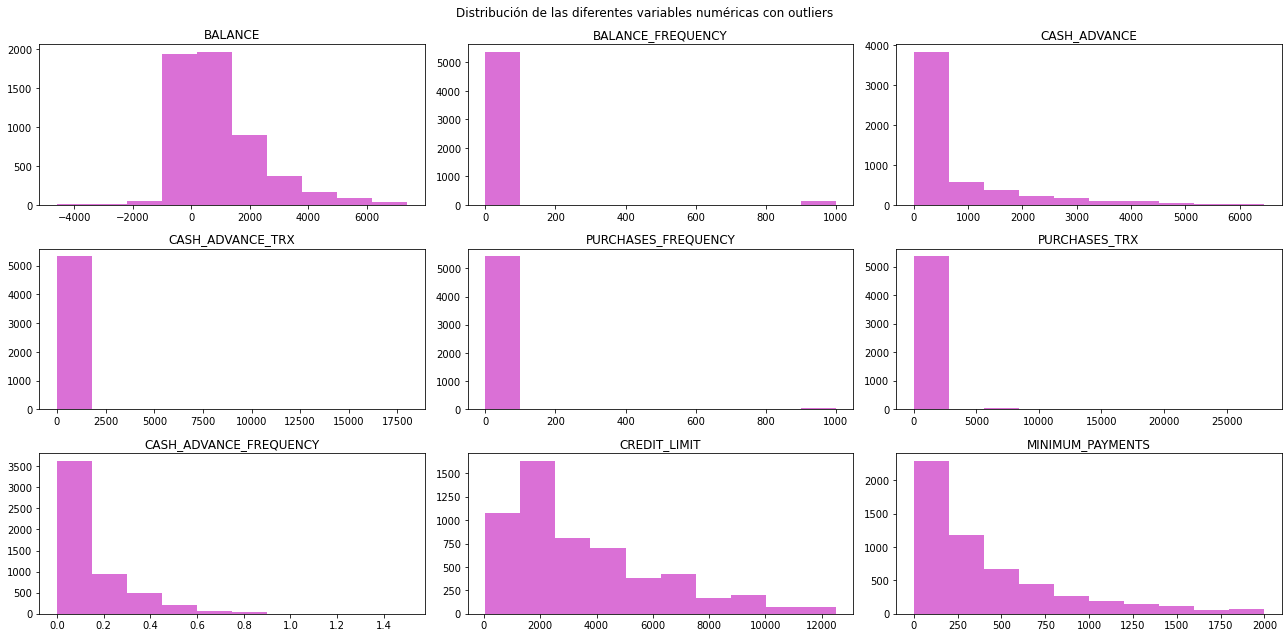

In [22]:
fig, axs = plt.subplots(3,3, figsize=(18,9))
k = 0
for i in range(3):
    for j in range(3):
        plot_distribuciones(list(dic_limites.keys())[k], axs, i, j)
        k += 1
plt.suptitle('Distribución de las diferentes variables numéricas con outliers')
plt.tight_layout()

**BALANCE:** Veamos primero la variable Balance:

In [23]:
print('La cantidad de datos por debajo del límite inferior es: {}'.format(len(datos[datos['BALANCE'] < 0])))
print('La cantidad de datos por encima del límite superior es: {}'.format(len(datos[datos['BALANCE'] > 5000])))

La cantidad de datos por debajo del límite inferior es: 165
La cantidad de datos por encima del límite superior es: 126


De acuerdo con el negocio y los expertos (foro del curso), los valores negativos son inadmisibles para este contexto. Por lo tanto, deben ser eliminados o imputados, como se hará más adelante. En este caso, como se mencionará más adelante, para variables con casos similares, utilizaremos una imputación con la media.

Para el límite superior, tenemos 126 datos que superan el balance que queda a los usuarios después de hacer sus compras. En lugar de eliminar estos datos, podríamos admitir los valores mayores a 5000 (que, primero, no son muchos y, segundo, superan el monto máximo por muy poco), si asumimos que son errores del conocimiento de datos del negocio.

**CASH_ADVANCE:** Algo similar sucede con esta variable. Veamos cuantos datos fuera del rango superior hay:

In [24]:
print('La cantidad de datos por encima del límite superior es: {}'.format(len(datos[datos['CASH_ADVANCE'] > 5000])))

La cantidad de datos por encima del límite superior es: 68


Realmente, el total de datos que se salen del rango es muy bajo y, por tanto, podríamos mantenerlos; suponiendo que es desconocimiento del negocio en este caso. No vemos por qué el usuario no podría más de 5000 en avance por un pago.

**CASH_ADVACE_TRX:** En este caso, el valor máximo del dataset lo tenemos en 18000. Es muy extraño, pues el máximo debería ser 15. Veamos cuántos datos hay mayores a 15, y cuáles son esos datos:

In [25]:
print('La cantidad de datos por encima del límite superior es: {}'.format(len(datos[datos['CASH_ADVANCE_TRX'] > 5000])))
datos['CASH_ADVANCE_TRX'][datos['CASH_ADVANCE_TRX'] > 15].value_counts().to_frame()

La cantidad de datos por encima del límite superior es: 11


CASH_ADVANCE_TRX
16.0                   25
17.0                   23
19.0                   19
1000.0                 18
2000.0                 14
3000.0                 13
18.0                   12
20.0                   11
5000.0                  7
4000.0                  5
6000.0                  3
8000.0                  2
18000.0                 1
12000.0                 1
7000.0                  1
10000.0                 1
14000.0                 1
17000.0                 1

Podemos ver que, en este caso, hay dos tipos de datos mayores a 15. Aquellos que están entre 16 y 20, y aquellos que están entre 1000 y 18000. Pareciera que estos últimos fueran el resultado de haber multiplicado por 1000 el número de transacciones dadas con CASH_ADVANCE_TRX. Realmente, es difícil que se den 18000 transacciones de este tipo en un banco, y pueden ser errores de digitación en el negocio. 

Podemos acomodar el rango para que el límite superior de la variable sea, ahora, 20 (tiene sentido que algunos usuarios hayan hecho 5 transacciones más con cash in advance, particularmente en escenarios particulares de permisos especiales dados por el negocio). Asimismo, dividiremos entre 1000 todas aquellas transacciones que representan valores entre 1000 y 180000.

In [26]:
datos['CASH_ADVANCE_TRX'].loc[datos['CASH_ADVANCE_TRX'] >= 1000] = datos['CASH_ADVANCE_TRX']/1000

En la anterior línea, dividimos entre 1000 todos los datos con valores mayores o iguales a 1000.

**PURCHASES_FREQUENCY:** Veamos qué sucede con los outliers en este caso:

In [27]:
print('La cantidad de datos por encima del límite superior es: {}'.format(len(datos[datos['PURCHASES_FREQUENCY'] > 1])))
datos['PURCHASES_FREQUENCY'][datos['PURCHASES_FREQUENCY'] > 1].value_counts().to_frame()

La cantidad de datos por encima del límite superior es: 117


PURCHASES_FREQUENCY
1000.000                   26
83.333                     14
500.000                    10
416.667                     9
333.333                     9
583.333                     8
166.667                     7
916.667                     6
250.000                     5
750.000                     5
833.333                     4
222.222                     2
142.857                     2
700.000                     2
818.182                     1
666.667                     1
100.000                     1
125.000                     1
300.000                     1
900.000                     1
714.286                     1
857.143                     1

Podemos asumir que en este caso ocurrió algo similar que en la variable anterior. Los valores fuera de rango, parecen multiplicados por 1000. Dividamos, entonces, todos estos valores entre 1000.

In [28]:
datos['PURCHASES_FREQUENCY'].loc[datos['PURCHASES_FREQUENCY'] > 1] = datos['PURCHASES_FREQUENCY']/1000

**PURCHASES_TRX:** Veamos qué sucede con los outliers en este caso:

In [29]:
print('La cantidad de datos por encima del límite superior es: {}'.format(len(datos[datos['PURCHASES_TRX'] > 1])))
datos['PURCHASES_TRX'][datos['PURCHASES_TRX'] > 30].value_counts().to_frame()

La cantidad de datos por encima del límite superior es: 3622


PURCHASES_TRX
7000.0              15
3000.0              13
1000.0               9
8000.0               9
2000.0               8
6000.0               8
12000.0              6
10000.0              5
4000.0               4
5000.0               4
24000.0              4
16000.0              4
14000.0              4
15000.0              4
21000.0              3
25000.0              3
11000.0              3
13000.0              3
18000.0              2
22000.0              1
28000.0              1
26000.0              1
9000.0               1
19000.0              1

Podemos asumir que en este caso ocurrió algo similar que en la variable anterior. Los valores fuera de rango, parecen multiplicados por 1000. Dividamos, entonces, todos estos valores entre 1000.

In [30]:
datos['PURCHASES_TRX'].loc[datos['PURCHASES_TRX'] > 30] = datos['PURCHASES_TRX']/1000

**CASH_ADVANCE_FREQUENCY:** En este caso, los datos fuera de rango van hasta 1.5, como se vio en etapas previas del entendimiento de los datos. En el histograma, se ve que son pocos los valores que están fuera de rango; y, como en este caso no ocurre lo de la multiplicación por 1000, lo más conveniente es seguir la estrategia de cambiarlos por NaN y después imputar con la media, como se verá más adelante.

**CREDIT_LIMIT:** En este caso, sucede algo similar al límite superior definido para BALANCE. Veamos cuántos datos se salen del rango (i.e. son mayores a 10000):

In [31]:
print('La cantidad de datos por encima del límite superior es: {}'.format(len(datos[datos['CREDIT_LIMIT'] > 10000])))

La cantidad de datos por encima del límite superior es: 136


Vemos que son pocos casos e, igual que en casos anteriores, podemos asumir que corresponde a problemas con el límite crediticio que tiene el negocio (quizá los datos están desactualizados). De acuerdo con el histograma, el valor máximo es apenas 12500, no muy distante del 10000 (proporcionalmente). Por lo tanto, podemos simplemente quedarnos con estos datos como están.

**MINIMUM_PAYMENTS:** Veamos qué sucede con los outliers en este caso:

In [32]:
print('La cantidad de datos por encima del límite superior es: {}'.format(len(datos[datos['MINIMUM_PAYMENTS'] > 1200])))

La cantidad de datos por encima del límite superior es: 393


En este caso, considerando el rango dado, el límite superior sí es excedido considerablemente. Con esta variable, podemos saber el mínimo número de pagos que hizo un usuario, y quizá más de 1200 es mucho. En este caso, para no asumir más información sobre el negocio, preferimos eliminarlos e imputarlos posteriormente con la media.

**TENURE:** En este caso, veamos los datos que son menores a 0:

In [33]:
print('La cantidad de datos por debajo del límite inferior es: {}'.format(len(datos[datos['TENURE'] < 0])))
datos['TENURE'][datos['TENURE'] < 0].value_counts().to_frame()

La cantidad de datos por debajo del límite inferior es: 148


TENURE
-12.0     124
-11.0       8
-7.0        6
-10.0       6
-8.0        2
-9.0        2

Vemos que solamente hay 6 valores, y que todos están en el rango [-7,-12]. Asumimos, entonces, que es un error de tipeo y que, en realidad, todos los valores son positivos. Por ello, usando la función <code>abs()</code>, transformamos a positivo todos los valores negativos de esta columna:

In [34]:
datos['TENURE'] = abs(datos['TENURE'])

----
Con esto, concluimos el análisis de cada columna por separado. Como dijimos previamente, hay algunos datos que, sin lugar a dudas deben ser imputados. Para ello, seguiremos la siguiente estrategia: Para todas las columnas vamos a realizar una imputacion con la media de los datos. Esto debido a que, el porcentaje máximo de celdas a imputar por cada columna sera de de 7.23%, que corresponde al porcentaje de celdas fuera de rango de la columna que más celdas fuera de rango tiene. Para esto, primero debemos volver nulos estos valores. (esta imputación se realizará en la siguiente sección)

In [35]:
def tratar_outliers(x, minimo, maximo):
    if x>=minimo and x<=maximo: 
        return x
    else: 
        return np.NaN

Redefinimos el diccionario con los nuevos valores máximos impuestos y vemos la cantidad de valores fuera de rango con las nuevas consideraciones:

In [36]:
dic_limites={"BALANCE":(0,max(datos["BALANCE"])),"CASH_ADVANCE":(0,max(datos["CASH_ADVANCE"])),"CASH_ADVANCE_TRX":(0,20),"PURCHASES_FREQUENCY":(0,1),"PURCHASES_TRX":(0,30),"CASH_ADVANCE_FREQUENCY":(0,1),"CREDIT_LIMIT":(0,max(datos["CREDIT_LIMIT"])),"MINIMUM_PAYMENTS":(0,1200),"TENURE":(1,12), "BALANCE_FREQUENCY":(0, 1)}
obtener_numero_outliers(dic_limites)

Datos fuera de rango para:
BALANCE                   165       
CASH_ADVANCE              0         
CASH_ADVANCE_TRX          0         
PURCHASES_FREQUENCY       0         
PURCHASES_TRX             0         
CASH_ADVANCE_FREQUENCY    2         
CREDIT_LIMIT              0         
MINIMUM_PAYMENTS          393       
TENURE                    0         
BALANCE_FREQUENCY         160       
En total hay 720 datos fuera del rango, esto representa el 13.02%  en el dataframe


Como era de esperarse, ahora las únicas columnas con outliers son: BALANCE (únicamente con datos negativos), CASH_ADVANCE_FREQUENCY (valores superiores a 1 - ¡son solo dos!) y MINIMUM_PAYMENTS (con valores superiores a 1200). 


A estos valores, aplicamos el tratamiento de los nulos.

In [37]:
for column in dic_limites.keys():
    datos[column] = datos[column].apply( tratar_outliers, args=(dic_limites[column][0], dic_limites[column][1]))

Como era de esperarse, ya no hay outliers en el conjunto de datos:

In [38]:
obtener_numero_outliers(dic_limites)

Datos fuera de rango para:
BALANCE                   0         
CASH_ADVANCE              0         
CASH_ADVANCE_TRX          0         
PURCHASES_FREQUENCY       0         
PURCHASES_TRX             0         
CASH_ADVANCE_FREQUENCY    0         
CREDIT_LIMIT              0         
MINIMUM_PAYMENTS          0         
TENURE                    0         
BALANCE_FREQUENCY         0         
En total hay 0 datos fuera del rango, esto representa el 0.00%  en el dataframe


### Manejo de nulos (celdas vacías)

Revisaremos el numero total de celdas vacías que tenemos

In [39]:
datos_con_null = datos[datos.isna().any(axis=1)]
print('La cantidad de filas con al menos una celda vacía es: ', len(datos_con_null))
print('El porcentaje de filas con celdas vacías es del {:.2f}%'.format((len(datos_con_null)*100)/len(datos)))

La cantidad de filas con al menos una celda vacía es:  1348
El porcentaje de filas con celdas vacías es del 24.38%


Este es un porcentaje considerable de los datos. En realidad, no vale la pena eliminarlos. Por lo tanto, como se dijo antes, seguiremos una estrategia de imputación con la media (al ser variables continuas).

In [40]:
for column in datos.columns:
    datos[column] = datos[column].replace(np.nan, datos[column].mean())

Revisamos que se haya realizado adecuadamente:

In [41]:
datos_con_null = datos[datos.isna().any(axis=1)]
print('La cantidad de filas con al menos una celda vacía es: ', len(datos_con_null))
print('El porcentaje de filas con celdas vacías es del {:.2f}%'.format((len(datos_con_null)*100)/len(datos)))

La cantidad de filas con al menos una celda vacía es:  0
El porcentaje de filas con celdas vacías es del 0.00%


### Preparacion de los datos según los modelos a usar

La mayoría de los algoritmos de clustering requieren que los datos estén normalizados para que el algoritmo arroje mejores resultados. Para ello, es conveniente utilizar un escalador: puede ser <code>MinMaxScaler()</code> o un estadarizador, <code>StandardScaler()</code>. Según la literatura [1], usualmente cualquier escalador es indiferente: los efectos sobre el desempeño de los datos son similares. En este caso, usaremos <code>MinMaxScaler()</code>, para conservar las distancias entre los datos, y normalizaremos los datos, para hacer que nuestros datos sean lo más gaussianos posible, que es ideal para los algoritmos de clustering.

Lo anterior se debe a que la normalización y estandarización permite eliminar datos redundantes, asegurar la buena calidad de los clústeres generados y mejorar la eficiencia de los algoritmos [7].



In [42]:
scaler = MinMaxScaler()
datos_escalados = scaler.fit_transform(datos)
datos_escalados = normalize(datos_escalados)
datos_viejos = datos.copy()
datos = pd.DataFrame(datos_escalados, columns=datos.columns)

Finalmente, ya con todos los datos tratados, conviene de nuevo realizar un mapa de correlación entre las variables:

In [43]:
corr = datos.corr()
corr

BALANCE  PURCHASES  BALANCE_FREQUENCY  CASH_ADVANCE  \
BALANCE                 1.000000  -0.111706           0.159844      0.449532   
PURCHASES              -0.111706   1.000000          -0.151208     -0.230338   
BALANCE_FREQUENCY       0.159844  -0.151208           1.000000     -0.009337   
CASH_ADVANCE            0.449532  -0.230338          -0.009337      1.000000   
CASH_ADVANCE_TRX        0.366760  -0.252820           0.052784      0.654204   
PURCHASES_FREQUENCY    -0.375959   0.415423          -0.167491     -0.406577   
PURCHASES_TRX          -0.276070   0.561000          -0.231080     -0.346661   
CASH_ADVANCE_FREQUENCY  0.379053  -0.275546           0.155239      0.621199   
CREDIT_LIMIT            0.192409   0.131905          -0.312791      0.112009   
PAYMENTS                0.106866   0.267433          -0.246729      0.306523   
MINIMUM_PAYMENTS        0.583559  -0.149381           0.137705      0.303037   
TENURE                 -0.257771  -0.154410          -0.419148     -0.261259   

                        CASH_ADVANCE_TRX  PURCHASES_FREQUENCY  PURCHASES_TRX  \
BALANCE                         0.366760            -0.375959      -0.276070   
PURCHASES                      -0.252820             0.415423       0.561000   
BALANCE_FREQUENCY               0.052784            -0.167491      -0.231080   
CASH_ADVANCE                    0.654204            -0.406577      -0.346661   
CASH_ADVANCE_TRX                1.000000            -0.415722      -0.349448   
PURCHASES_FREQUENCY            -0.415722             1.000000       0.799637   
PURCHASES_TRX                  -0.349448             0.799637       1.000000   
CASH_ADVANCE_FREQUENCY          0.846242            -0.448687      -0.387557   
CREDIT_LIMIT                   -0.049976            -0.098985      -0.030406   
PAYMENTS                        0.142778            -0.130519      -0.015014   
MINIMUM_PAYMENTS                0.259879            -0.354079      -0.265855   
TENURE                         -0.233634            -0.321836      -0.235829   

                        CASH_ADVANCE_FREQUENCY  CREDIT_LIMIT  PAYMENTS  \
BALANCE                               0.379053      0.192409  0.106866   
PURCHASES                            -0.275546      0.131905  0.267433   
BALANCE_FREQUENCY                     0.155239     -0.312791 -0.246729   
CASH_ADVANCE                          0.621199      0.112009  0.306523   
CASH_ADVANCE_TRX                      0.846242     -0.049976  0.142778   
PURCHASES_FREQUENCY                  -0.448687     -0.098985 -0.130519   
PURCHASES_TRX                        -0.387557     -0.030406 -0.015014   
CASH_ADVANCE_FREQUENCY                1.000000     -0.064544  0.117978   
CREDIT_LIMIT                         -0.064544      1.000000  0.184190   
PAYMENTS                              0.117978      0.184190  1.000000   
MINIMUM_PAYMENTS                      0.249154     -0.053681  0.068299   
TENURE                               -0.294822     -0.032279 -0.009334   

                        MINIMUM_PAYMENTS    TENURE  
BALANCE                         0.583559 -0.257771  
PURCHASES                      -0.149381 -0.154410  
BALANCE_FREQUENCY               0.137705 -0.419148  
CASH_ADVANCE                    0.303037 -0.261259  
CASH_ADVANCE_TRX                0.259879 -0.233634  
PURCHASES_FREQUENCY            -0.354079 -0.321836  
PURCHASES_TRX                  -0.265855 -0.235829  
CASH_ADVANCE_FREQUENCY          0.249154 -0.294822  
CREDIT_LIMIT                   -0.053681 -0.032279  
PAYMENTS                        0.068299 -0.009334  
MINIMUM_PAYMENTS                1.000000 -0.156372  
TENURE                         -0.156372  1.000000

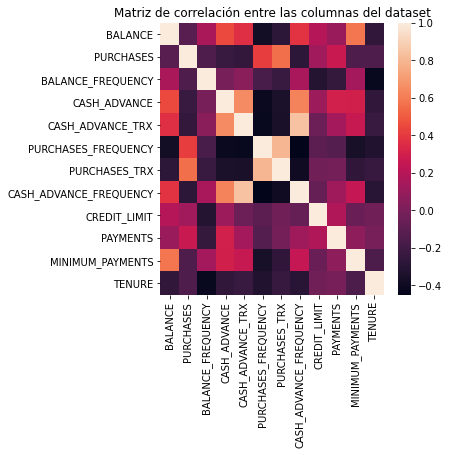

In [44]:
plt.figure(figsize=(5,5))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
plt.title('Matriz de correlación entre las columnas del dataset')
plt.show()

Vemos que después del procesamiento, hay algunas correlaciones que se hacen más evidentes (como, por ejemplo, la de 0.83 entre PURCHASES_FREQUENCY y PURCHASES_TRX, así como la de 0.87 entre CASH_ADVANCE_FREQUENCY y CASH_ADVANCE_TRX. Esto será importante posteriormente en la definición de las columnas que usaremos para los algoritmos. MINIMUM_PAYMENTS y BALANCE, por ejemplo, también guardan una correlación positiva de 0.6. 

Para poder manejar estas correlaciones, una de las mejores estrategias es utilizar PCA. No obstante, esto se hará más adelante en la construcción de cada uno de los modelos.

## 3. Modelamiento
Para este laboratorio, elegimos tres algoritmos de clustering: K-means, hierarchical clustering y affinity propagation.

### 3.3 Hierarchical Clustering
El tercer algoritmo que utilizamos fue el clustering jerárquico. Lo anterior pues, de acuerdo con la literatura, es uno de los que mejor se comporta para datasets pequeños (consideramos pequeño un dataset de aproximadamente 5000 datos) [2,3]. 

El clustering jerárquico es un método de análisis que busca construir una jerarquía de clústeres (agrupando objetos similares); es decir, construye estructuras tipo árbol basadas en la jerarquía. Existen dos tipos de clustering jerárquico: aglomerativo y divisivo. Debido a que el aglomerativo es el que se encuentra implementado en <code>sklearn</code>, este es el que usaremos en este laboratorio [4].

El clustering jerárquico aglomerativo, también conocido como aproximación ascendente, trata cada fila de datos como un clúster singletón (i.e. un clúster de un solo dato) y, sucesivamente, aglomera pares de clústeres hasta que todos son unidos en un único clúster de datos [5]. En la siguiente imagen, podemos ver un ejemplo de este tipo de algoritmo:

<img width=40% src='images/HAC.png'>
Como vemos, todos los datos están separados al principio y, a medida que avanza el algoritmo, se van juntando en clústeres. 

Es importante resaltar que una de las mayores ventajas del clústering aglomerativo es que no necesita pre-especificar un número determinado de clústeres, pues puede determinarse con un dendrograma, como se verá más adelante.

### 3.3.1 Modelo básico 
Primero, implementaremos un modelo básico, sin búsqueda de hiperparámetros, y asumiendo aspectos importantes o usando valores por defecto de las librerías.
#### 3.3.1.1 Dendrogramas
Los dendrogramas son estructuras en forma de árboles que permiten visualizar el historial de agrupamientos y encontrar el número óptimo de clústeres. Aunque en realidad el número de clusteres es un hiperparámetro que podemos encontrar haciendo uso de herramientas como el coeficiente silueta, podemos darnos una idea inicial con el dendrograma, para limitar nuestro espacio de búsqueda. 

El dendrograma lo construimos usando la librería <code>scipy</code> de Python. Un ejemplo de un dendrograma lo podemos ver a continuación [6].
<img width=90% src='images/dendrogram_ejemplo.png'/>
Analíticamente, la idea es encontrar la distancia vertical más larga que NO sea atravesada por una línea horizontal. En el caso del ejemplo de la derecha, es la línea etiquetada con 5. En el caso de la imagen de la izquierda, es cualquiera de las dos líneas azules. Luego, hasta antes de llegar a dicha distancia, trazamos una línea horizontal y determinamos cuántas líneas verticales cruza. Ese es el número ideal de clusteres para el problema jerárquico. En el caso de la izquierda, son dos. En el de la derecha, son 5. 

El dendrograma recibe, además, un (hiper)parámetro para saber cómo calcular las distancias entre clústere, como se ve a continuación:
<img width=70% src='images/linkage.png'/>
* Single Linkage: La distancia entre dos clústeres es la distancia más corta, dada por los dos puntos más cercanos de ambos clústeres.
* Complete Linkage: La distancia entre dos clústeres es la distancia más grande, dada por los dos puntos más alejados de ambos clústeres.
* Average Linkage: La distancia entre dos clústeres es la distancia promedio entre cada punto de un clúster a cada punto del otro clúster.
* Ward Linkage: La distancia entre clústeres es la suma de diferencias cuadradas dentro de todos los clústeres. Es la de mejor desempeño y la que se utiliza por defecto, al minimizar la varianza de los clústeres que se van a unir. Por lo tanto, es la que utilizaremos en el modelo base.

Construyamos ahora nuestro dendrograma:

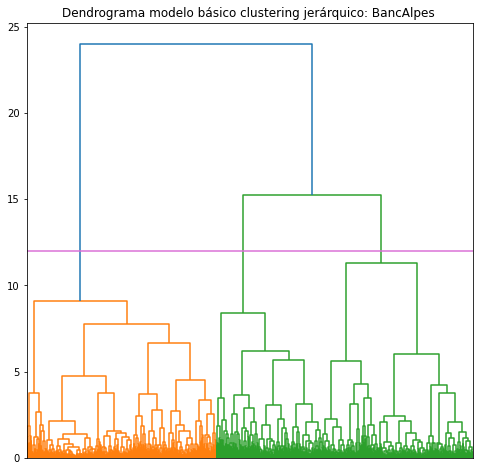

In [45]:
plt.figure(figsize =(8, 8))
plt.title('Dendrograma modelo básico clustering jerárquico: BancAlpes ')
Dendrogram = sch.dendrogram((sch.linkage(datos, method ='ward')))
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
plt.axhline(y=12, color='orchid', linestyle='-')
plt.savefig('images/dendrograma_hierarchical_basico.png')

Del dendrograma mostrado en la celda anterior y lo explicado previamente, es claro que el número de clústeres ideal para este problema es 3, como indica la línea púrpura. Por lo tanto, en nuestro modelo inicial, usaremos tres clústeres.

Antes de construir el modelo inicial, es necesario entender los hiperparámetros de clústering por aglomeración que usa <code>sk-learn</code>:
* n_clusters: el número de clústeres a encontrar. En el caso del modelo inicial, usamos el obtenido con el método del dendrograma.
* affinity: La forma de calcular las distancias. Puede ser manhattan (i.e. valor absoluto), l1 (regresión Lasso), l2 (regresión Ridge) o euclideana. Sólo se acepta distancia euclideana si el linkage fue ward. _Nota:_ Las regresiones Lasso y Ridge fueron explicadas en el laboratorio pasado. 
* memory: Guarda en una caché las combinaciones del árbol. No es relevante para el modelo y no afecta. Por defecto, no se guarda.
* connectivity: para cada muestra, define sus muestras vecinas. Por defecto no hay, y debe ser definida por el usuario. Por lo tanto, no se tendrá en cuenta ni aquí ni en la búsqueda de hiperparámetros.
* compute_full_tree: Parar la construcción temprana del árbol en n_clusters. El valor por defecto es <code>auto</code>, tal que el algoritmo decida cuando es hora de parar de construir el árbol. Este hiperparámetro lo dejaremos así, tanto para el modelo inicial, como para el de búsqueda de hiperparámetros.
* linkage: Criterio de unión de clusteres. Son los mismos definidos previamente para el dendrograma.
* distance_threshold: La distancia a partir de la cual no se unirán clusteres. Es un método alternativo para cuando no se sabe el número de clústeres. Por defecto, es None, pues es difícil y dependiente del problema encontrar el valor para el cual no deben unirse más los clusteres. Lo dejaremos de esta forma tanto para el modelo inicial como para el de búsqueda de hiperparámetros.
* compute_distances: Por defecto es False, pues puede incurrir en un gran gasto de memoria. Crea la visualización de dendrogramas. No lo usaremos pues los construimos con <code>scipy</code>.
---
En este sentido, construimos nuestro modelo básico con:

``` n_clusters = 3
affinity='euclidean'
linkage='ward' ```

A su vez, hacemos fit:

In [46]:
hierarchical_basico = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
hierarchical_basico.fit(datos)

AgglomerativeClustering(n_clusters=3)

Tomamos las <code>labels</code> construidas:

In [47]:
labels_hierarchical_basico = hierarchical_basico.labels_

Veamos la cantidad de datos en cada clúster:

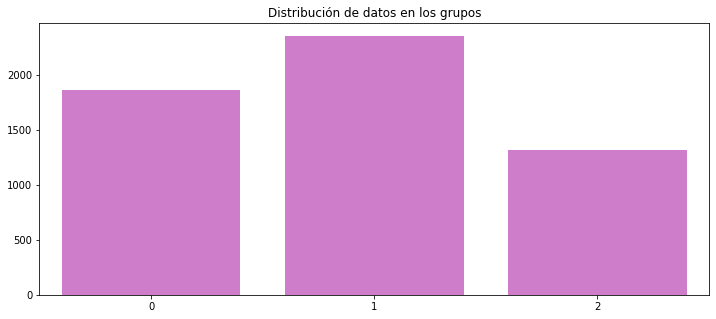

In [48]:
datos['cluster_basico'] = labels_hierarchical_basico
cluster_distrib = datos['cluster_basico'].value_counts()

fig=plt.figure(figsize=(12,5))
sns.barplot(x=cluster_distrib.index, y=cluster_distrib.values, color='orchid')
plt.title('Distribución de datos en los grupos')
plt.grid(0)

Más específicamente:

In [49]:
datos['cluster_basico'].value_counts().to_frame()

cluster_basico
1            2354
0            1863
2            1313

Podemos ver que la mayor cantidad de datos caen en la categoría 0, unos menos en la 1 y, finalmente, el que menos datos tiene es la categoría 2. No obstante, los valores no son muy disímiles; tal que es posible que el algoritmo esté haciendo un buen trabajo. Para poder saber esto con precisión, es necesario hacer búsqueda de hiperparámetros (usando métodos como el de silueta) para, así, encontrar el número ideal de clústeres.

Para saber las características de cada uno de los grupos, podemos graficar las variables en parejas. Esto es un trabajo un poco demorado y, por tanto, prefiero hacer primero la búsqueda de hiperparámetros para, con ello, hablar de lo definido por el mejor modelo. 

### 3.3.2 Modelo con búsqueda de hiperparámetros

Para hallar el número clusteres, usamos el método del coeficiente silueta. Sabiendo que con el método de los dendrogramas el número de clusteres fue de 3, podemos definir el espacio de búsqueda del número óptimo de clústeres entre 2 y 9: 1 antes del encontrado por el método del dendrograma, y algunos varios después para ver cómo disminuye el coeficiente silueta.

Otros de los dos hiperparámetros que consideraría relevantes para este caso son la afinidad y el linkage. No obstante, probar los posibles valores de estos dos hiperparámetros junto con los 4 tamaños de clusteres definidos es una tarea computacional bastante costosa. Investigando, nos dimos cuenta que, para datos multivariados, el mejor método de linkage es el de Ward [8,9]. Por verificar, hacemos búsqueda de los otros hiperparámetros. En linkage, solamente usamos Ward y average, que son los más relevantes. En afinidad, usamos l1 (la más robusta de las lineales), euclideana y coseno. Recordemos que ward únicamente usa euclideana, entonces para ella no es necesario hacer búsqueda sobre afinidades. Al final, nos quedamos con el mejor coeficiente silueta de todos.

In [50]:
# Identificar el valor del numero de clusteres, utilizando ahora el valor de la silueta
def plot_silhoute_best_model(data, lista_num_clusteres, lista_afinidades, lista_linkages):
    '''
    Graficar el codo de los clusters
    
    Parametros
    ----------
    data : np.array
        El arreglo con los datos
    k_min : int
        Valor mínimo para k
    k_max : int
        Valor máximo para k
    xlabel : string
        La etiqueta del eje x
    ylabel  string
        La etiqueta del eje y    
    title : string
        El titulo de la gráfica  
    '''
    # Crear una lista para almacenar los coeficientes de la silueta para cada valor de k analizado
    for l in lista_linkages:
        if l =='ward':
            silhouette_coefficients_ward = []
            best_model_ward = None
            for n in lista_num_clusteres:
                model = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
                model.fit(data)
                score = silhouette_score(data, model.labels_)
                silhouette_coefficients_ward.append(score)
                if score == max(silhouette_coefficients_ward):
                    best_model_ward = model
            plt.plot(range(lista_num_clusteres[0], lista_num_clusteres[-1]+1), silhouette_coefficients_ward, color='orchid')
            plt.xticks(range(lista_num_clusteres[0], lista_num_clusteres[-1]+1))
            plt.xlabel('Numero de clusteres')
            plt.ylabel('Coeficiente silueta')
            plt.title('Valores del coeficiente silueta con linkage Ward')
            plt.grid(0)
            plt.show()
            print('El valor del mejor coeficiente silueta es: {}'.format(max(silhouette_coefficients_ward)))
        else:
            best_model_average = None
            chosen_a = ''
            for a in lista_afinidades:
                silhouette_coefficients_average = []
                for n in lista_num_clusteres:
                    model = AgglomerativeClustering(n_clusters=n, affinity=a, linkage=l)
                    model.fit(data)
                    score = silhouette_score(data, model.labels_)
                    silhouette_coefficients_average.append(score)
                    if score == max(silhouette_coefficients_average):
                        best_model_average = model
                        chosen_a = a
                plt.plot(range(lista_num_clusteres[0], lista_num_clusteres[-1]+1), silhouette_coefficients_average, color='pink')
                plt.xticks(range(lista_num_clusteres[0], lista_num_clusteres[-1]+1))
                plt.xlabel('Numero de clusteres')
                plt.ylabel('Coeficiente silueta')
                plt.title('Valores del coeficiente silueta con linkage Average y afinidad {}'.format(chosen_a))
                plt.grid(0)
                plt.show()
                print('El valor del mejor coeficiente silueta es: {}'.format(max(silhouette_coefficients_average)))

    return best_model_ward, best_model_average

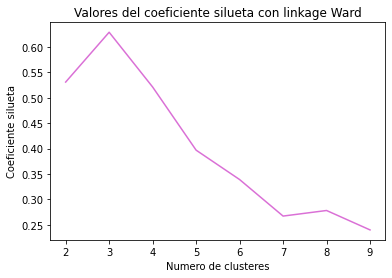

El valor del mejor coeficiente silueta es: 0.6286932706533063


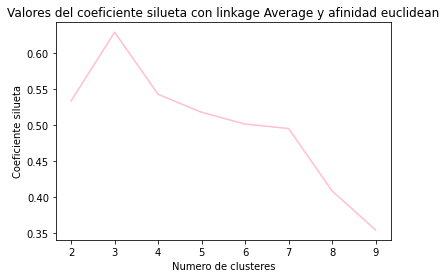

El valor del mejor coeficiente silueta es: 0.6286932706533063


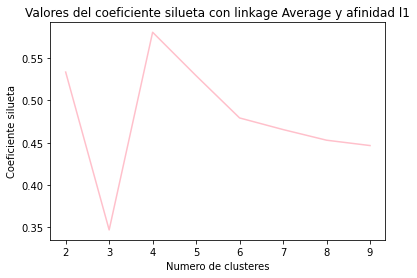

El valor del mejor coeficiente silueta es: 0.5806085857621834


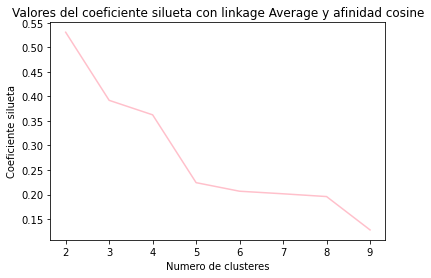

El valor del mejor coeficiente silueta es: 0.5307037948186216


In [51]:
lista_num_clusteres = [i for i in range(2,10)]
lista_afinidades=['euclidean', 'l1', 'cosine']
lista_linkages=['ward', 'average']

best_model_hierarchical = plot_silhoute_best_model(datos, lista_num_clusteres, lista_afinidades, lista_linkages)

### Validación

A partir de la anterior celda, vemos que el mejor coeficiente silueta es de 0.628693270653306. Esto ocurre para 3 clústeres. Podemos ver que la gráfica que usa afinidad de coseno es las única que prefiere 2 clústeres, contrario a lo que decía el dendrograma, pero es el del menor coeficiente silueta. Asimismo, la de afinidad l1 prefiere 4 clusteres, pero con un coeficiente silueta menor que el de 3 clusteres con distancia euclidiana y linkage average/ward. Por lo tanto, concluimos que el mejor número de clústeres, al ser el que maximiza el coeficiente silueta, es 3. 

En cuanto al linkage, vemos que el valor del coeficiente silueta es igual en los dos primeros casos. Por lo tanto, nos quedaremos con el modelo con 3 clústeres, usando afinidad euclideana y linkage Ward, como lo recomienda la literatura y como elegimos al comienzo. Los tres hiperparámetros escogidos son:
```
n_clusters = 3
linkage = 'ward'
affinity = 'euclidean'```

Note que además los 3 clústeres coinciden con lo encontrado por el método del dendrograma muy usado en aplicaciones de clustering jerárquico, algunas celdas atrás. 

<img height=15% src='images/dendrograma_hierarchical_basico.png'/>

Asimismo, la distribución de clases elegida por el algoritmo será la misma que se mostró para el modelo inicial; pues la búsqueda de hiperparámetros arrojó los mismos resultados.

<img width=70% height=15% src='images/distribu.png'/>

Finalmente, vemos una visualización del coeficiente silueta para los tres clústeres:

In [52]:
best_model = best_model_hierarchical[0]
best_labels = best_model.labels_
datos.drop('cluster_basico', axis=1, inplace=True)
cols = list(datos.columns)
datos['CLUSTER'] = best_labels
datos_viejos['CLUSTER'] = best_labels

In [53]:
def plot_silhouette(data, 
                    labels,
                   ylabel = 'Clústeres',
                   xlabel = "Silhouette coefficient",
                   title = 'Silhouette Plot'):
    '''
    Graficar la silueta de los clusters
    
    Parametros
    ----------
    data : np.array
        El arreglo con los datos
    labels : np.array
        El arreglo con las etiquetas correspondientes
    ylabel  string
        La etiqueta del eje y
    xlabel : string
        La etiqueta del eje x
    title : string
        El titulo de la gráfica        
    '''
    cluster_labels = np.unique(labels)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(data,
                                        labels,
                                        metric='euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[labels == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper),
                        c_silhouette_vals,
                        height=1.0,
                        edgecolor='none',
                        color=color)
        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg,
                color="red",
                linestyle="--")
    plt.yticks(yticks, cluster_labels)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()

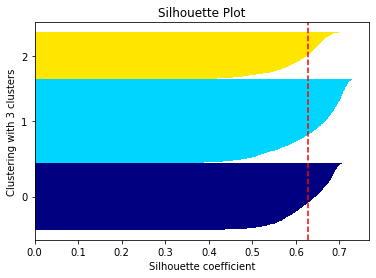

In [54]:
plot_silhouette(data = datos, 
                labels = best_labels, 
                ylabel = f'Clustering with 3 clusters')

Lo primero que vemos es que no tenemos coeficientes silueta negativos, tal que parece ser que todos los datos fueron asignados a la clase que debían ser asignados.

Segundo, vemos que el clúster de menor tamaño es el clúster 2; y, desde allí, el clúster 1 es el más grande y el 0 el de tamaño intermedio.

Entre más alto sea el valor del coeficiente silueta, más alejados están los clústeres entre sí. En nuestro caso, un valor de 60% es bastante bueno para separar tres grupos de clientes de BancAlpes. Es importante aclarar que, aunque se sale del enfoque del curso y del laboratorio, una forma de obtener mejores resultados sería aplicando un PCA sobre los datos. No hicimos esto para obtener mejor información sobre las variables "limpias" del dataset.

El análisis cualitativo se realiza a continuación.

----
Ahora, conviene hacer una validación descriptiva de las variables. Recordemos que nuestro problema tiene muchas variables categóricas y, por tanto, para hacer el análisis es necesario tener en cuenta. 

Lo primero que hacemos es intentar ver la distribución de las clases en cada una de las columnas. Así, podemos ver cuáles son las variables que tienen un mayor efecto sobre el clustering.

Lo que hacemos ahora es agrupar los datos, de acuerdo con los clusteres, por cada una de las variables del problema.

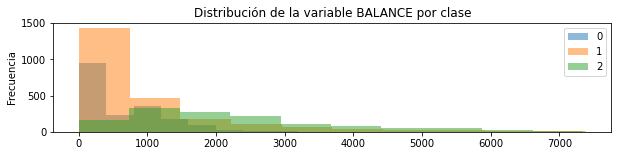

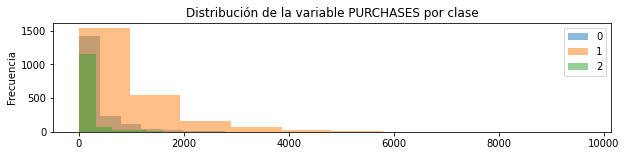

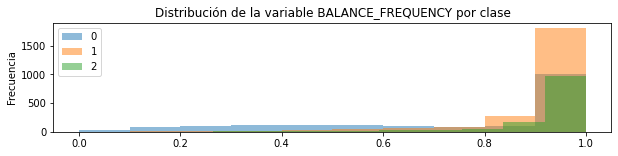

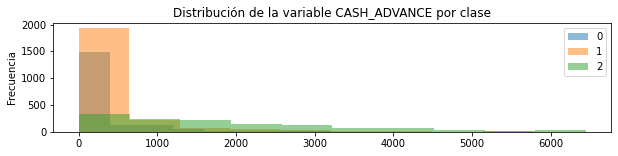

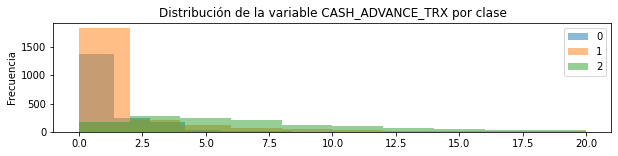

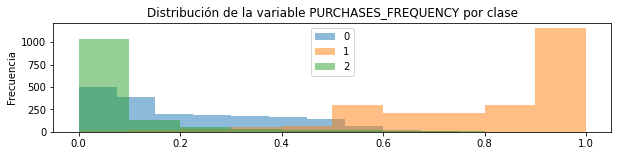

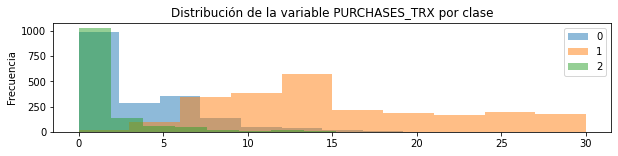

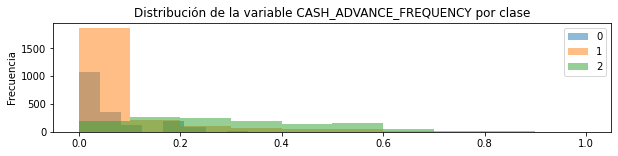

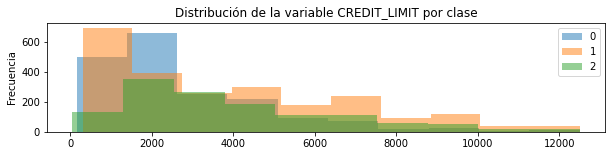

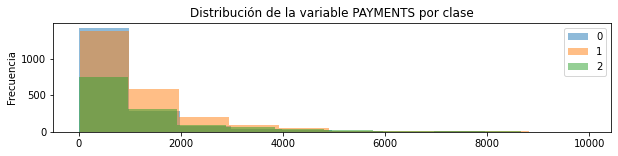

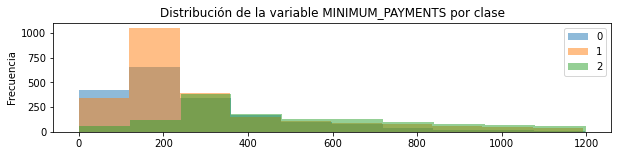

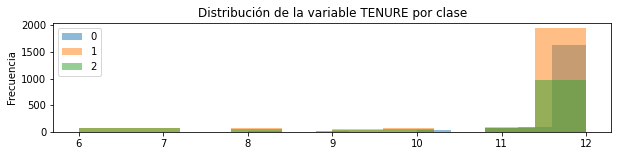

In [55]:
for c in cols:
    plt.figure(figsize=(10,2))
    colors = ['orchid', 'pink', 'turquoise']
    datos_viejos.groupby(datos_viejos['CLUSTER'])[c].hist(legend=True, alpha=0.5)
    plt.grid(0)
    plt.ylabel('Frecuencia')
    plt.title('Distribución de la variable {} por clase'.format(c))

Veamos cada una de las gráficas de la distribución. Recordemos que los datos están escalados y normalizados. Por esto, usamos el dataframe de datos viejos para entender mejor las distribuciones.

* **BALANCE:** Del histograma obtenido podemos ver que la clase 2 tiene un balance más distribuido en todo el rango de valores. Podemos concluir que los clientes de los grupos 0 y 1 consumen más o tienen cupos más pequeños, pues tienen balances más pequeños que los del grupo 2 (quienes, en general, están más distribuidos).
* **PURCHASES:** De esta variable la información más relevante que podemos obtener es que casi todos los clientes tipo 1 realizan 1000 compras en su cuenta. Son, además, los que más compras realizan. Los clientes tipo 2 realizan todos menos de 100 compras. Esto tiene sentido pues los clientes tipo 2 son los que mayor balance distribuido tienen. Asimismo, vemos que los clientes tipo 0 también realizan muy pocas compras. Esto se debe a que tienen un balance pequeño.
* **BALANCE_FREQUENCY:** La distribución de balance es más alta para los clientes tipo 1. Esto significa que su balance es el que más se actualiza. Tiene sentido, al ser los que más compras hacen.
* **CASH_ADVANCE:** Esta variable nos dice de cuanto es el valor de los pagos realizados por los clientes. Los lientes tipo 0 son lo que menos hacen, seguidos de los tipo 1. Los clientes tipo dos están distribuidos a lo largo de todo el rango pero, como son los de mayor poder adquisitivo al parecer, pueden hacer pagos de grandes sumas monetarias.
* **CASH_ADVANCE_TRX:** Nos da la misma información de CASH_ADVANCE. Esto justifica el hecho de querer hacer un PCA a futuro.
* **PURCHASES_FREQUENCY:** Esta variable da muy buena información de clusterización. Vemos que los clientes tipo 1 son los que compran más a menudo; mientras que, los tipo 0 y 2, son los que menos compras realizan.
* **PURCHASES_TRX:** Los clientes tipo 1 hacen, en promedio, una mayor cantidad de transacciones de compras. Les siguen los clientes tipo 0 y, finalmente, los tipo 2. Estos son los que menos compras realizan.
* **CASH_ADVANCE_FREQUENCY:** Nos da información similar a CASH_ADVANCE y CASH_ADVANCE_TRX.
* **CREDIT_LIMIT:** Vemos que los usuarios tipo 1 y tipo 2 tienen una distribución similar de límite de crédito en la tarjeta. Los de tipo 0, por el contrario, tienen poquito cupo en general.
* **PAYMENTS:** No da información muy diciente sobre el clustering realizado.
* **MINIMUM_PAYMENTS:** No da información muy diciente sobre el clustering realizado.
* **TENURE:** No da información muy diciente sobre el clustering realizado. Casi todos los usuarios han tenido la tarjeta por 12 meses.

Finalmente, miremos la media de cada clase. Para poder mirar adecuadamente todos los datos, uso los datos normalizados:

In [56]:
def get_columns_names(cols: pd.core.indexes.base.Index) -> dict:
    new_columns = {}
    new_columns['index'] = 'column'
    for i in range(1,len(cols)):
        new_columns[cols[i]] = int(str(i))
    return new_columns

In [57]:
datos_media_cluster = datos.groupby(datos['CLUSTER']).mean()
datos_media_cluster = datos_media_cluster.transpose()
datos_media_cluster.reset_index(inplace=True)
datos_media_cluster.rename(columns=get_columns_names(datos_media_cluster.columns), inplace=True)

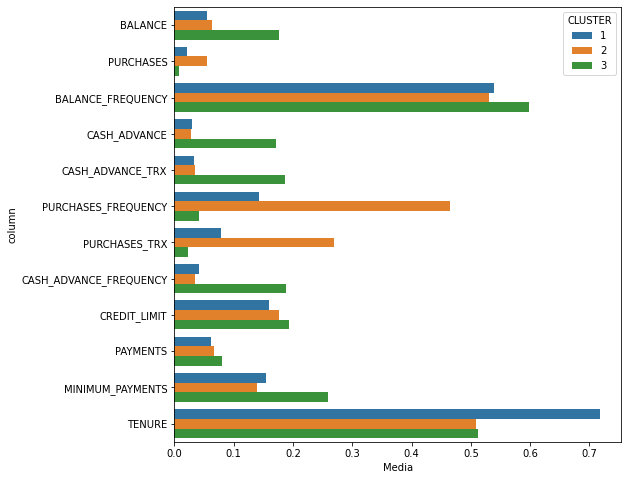

In [58]:
resp = []
for i in range(1, 3+1):
    df1 = datos_media_cluster[['column',i]].rename(columns = {i:'Media'})
    df1['CLUSTER'] = i
    resp.append(df1)

df_plot = pd.concat(resp, ignore_index = True)


fig = plt.figure(figsize=(8,8))
sns.barplot(data = df_plot, y = 'column', x = 'Media', hue = 'CLUSTER', orient = 'h')
plt.show()

Vemos que el cluster con mayor balance (i.e. con mayor cupo disponible) es el 3, y es el que menos compras realiza. Los del tipo 2 tienen un balance más bajo, pero realizan más compras considerablemente. Los del grupo 1 tienen un balance más bajo inclusive, pero compran menos. 

Los del grupo 3 son los que hace pagos más grandes por adelantado (CASH_ADVANCE). Vemos que, en general, toda la información es concordante con lo descrito previamente.

Este modelo es el que se eligió. Para las conclusiones, remítase al informe asociado a este laboratorio.

In [59]:
# Guardar los datos.
datos_viejos.to_csv('datos.csv', index=False)  

## 6. Bibliografía
[1] Géron (2019). Hands-On Machine Learning with Scikit-Learn, Keras and Tensorflow.

[2] https://www.sciencedirect.com/topics/mathematics/hierarchical-clustering

[3] https://stats.stackexchange.com/questions/217875/clustering-very-small-datasets#:~:text=For%20tiny%20data%20sets%2C%20hierarchical,and%20how%20many%20clusters%20exist.

[4] https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering

[5] https://www.geeksforgeeks.org/ml-hierarchical-clustering-agglomerative-and-divisive-clustering/

[6] https://medium.com/@sametgirgin/hierarchical-clustering-model-in-5-steps-with-python-6c45087d4318

[7] https://arxiv.org/pdf/1503.00900.pdf#:~:text=Normalization%20is%20used%20to%20eliminate,in%20the%20differences%5B3%5D.

[8] https://journalofinequalitiesandapplications.springeropen.com/articles/10.1186/1029-242X-2013-203#:~:text=Hands%20and%20Everitt%20%5B18%5D%20compared,overall%20than%20other%20hierarchical%20methods.

[9] Hands S, Everitt B: A Monte Carlo study of the recovery of cluster structure in binary data by hierarchical clustering techniques. Multivar. Behav. Res. 1987, 22: 235–243. 10.1207/s15327906mbr2202_6